# Ensure Supercell Size is Reasonable
CP2K's a flexible code, but it's preferred recipe for wavefunction optimization doesn't work with multiple k-points. That's a problem for small unit cells because we cannot ensure adaquate sampling of the reciprocal space with planewaves. We overcome this by making supercell becaue the plan is to run large-cell calculations of surfaces adsorption or bulk anyway.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from ase.db import connect
import pandas as pd
import numpy as np

## Load Results
Get the energy and volume per atom for each computation. 

In [2]:
results = []
with connect('cp2k-relax.db') as db:
    for row in db.select(''):
        results.append({
            'name': row.key_value_pairs['name'],
            'supercell': row.key_value_pairs['supercell'],
            'volume': row.volume / row.natoms,
            'energy': row.energy / row.natoms
        })
results = pd.DataFrame(results)
print(f'Loaded {len(results)} calculations for {len(set(results["name"]))} compositions')

Loaded 49 calculations for 25 compositions


## Summarize Results
Get the energy and volume at the largest supercell size

In [3]:
largest_cell = results['supercell'].max()
largest_result = results.query(f'supercell == {largest_cell}')
print(f'Retreived {len(largest_result)} calculations at the largest cell size ({largest_cell})')

Retreived 9 calculations at the largest cell size (4)


Get statistics about difference in energy and volume between 

In [4]:
supercell_stats = []
for size, group in results.groupby('supercell'):
    merged = largest_result.merge(group, on='name', how='inner', suffixes=('_large', '_small'))

    summary = {'size': size, 'n': len(merged)}
    for prop in ['energy', 'volume']:
        errors = (merged[f'{prop}_large'] - merged[f'{prop}_small']).abs()
        summary.update({
            f'{prop}_diff_mean': errors.mean(),
            f'{prop}_diff_std': errors.std(),
            f'{prop}_diff_max': errors.max()
        })

    supercell_stats.append(summary)
supercell_stats = pd.DataFrame(supercell_stats)
supercell_stats

,size,n,energy_diff_mean,energy_diff_std,energy_diff_max,volume_diff_mean,volume_diff_std,volume_diff_max
0,1,7,2.412133,0.661255,3.548542,2.376748,1.314203,3.978179
1,2,9,0.153899,0.143620,0.429052,0.101633,0.075141,0.251002
2,3,8,0.091897,0.136330,0.411185,0.072079,0.137732,0.410732
3,4,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


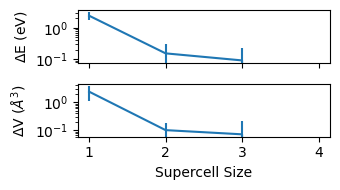

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.), sharex=True)

axs[0].errorbar(supercell_stats['size'], supercell_stats['energy_diff_mean'], yerr=supercell_stats['energy_diff_std'])
axs[0].set_yscale('log')
axs[0].set_ylabel('$\Delta$E (eV)')

axs[1].errorbar(supercell_stats['size'], supercell_stats['volume_diff_mean'], yerr=supercell_stats['volume_diff_std'])
axs[1].set_yscale('log')
axs[1].set_ylabel('$\Delta$V ($\\AA^3$)')

axs[1].set_xlabel('Supercell Size')
fig.tight_layout()

A supercell size of 2 is at least large enough to avoid major issues with volume relaxation